In [1]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib
import shap
import pickle
from matplotlib.colors import ListedColormap

# Default plot parameters
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['figure.dpi'] = 80
matplotlib.rcParams['figure.figsize'] = [5, 5]
cm = plt.cm.get_cmap('RdBu')
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':20,
         'ytick.labelsize':20}
plt.rcParams.update(params)
matplotlib.rcParams['font.sans-serif'] = "Arial"
plt.rcParams.update({'figure.autolayout': False})

In [2]:
class benchmark ():
    def __init__(self):
        self.numTest = 80
        self.numBase = 64
        self.colors = ['#FF8300', '#01A982', '#2CBCE4', '#FEC901', '#FF8300', '#01A982', '#2CBCE4']
        self.label = ['Sex', 'Age', 'physical_activity', 'Serum\nalbumin',
                   'alkaline_phosphatase', 'alkaline_phosphatase_isUnacceptable',
                   'alkaline_phosphatase_isTestnotdone', 'SGOT', 'SGOT_isUnacceptable',
                   'SGOT_isTestnotdone', 'BUN', 'BUN_isUnacceptable', 'BUN_isTestnotdone',
                   'calcium', 'calcium_isUnacceptable', 'calcium_isTestnotdone',
                   'creatinine', 'creatinine_isUnacceptable', 'creatinine_isTestnotdone',
                   'potassium', 'potassium_isUnacceptable', 'sodium',
                   'sodium_isUnacceptable', 'Total bilirubin',
                   'total_bilirubin_isUnacceptable', 'total_bilirubin_isTestnotdone',
                   'serum_protein', 'Red blood cells', 'red_blood_cells_isUnacceptable',
                   'red_blood_cells_isBlankbutapplicable', 'white_blood_cells',
                   'white_blood_cells_isUnacceptable',
                   'white_blood_cells_isBlankbutapplicable', 'hemoglobin',
                   'hemoglobin_isMissing', 'hematocrit', 'hematocrit_isUnacceptable',
                   'hematocrit_isMissing', 'platelets_isNormal', 'platelets_isIncreased',
                   'platelets_isDecreased', 'platelets_isNoestimate',
                   'Segmented neutrophils', 'lymphocytes', 'monocytes', 'eosinophils',
                   'basophils', 'band_neutrophils', 'Cholesterol', 'cholesterol_isMissing',
                   'urine_albumin_isNegative', 'urine_albumin_is>=30',
                   'urine_albumin_is>=100', 'urine_albumin_is>=300',
                   'urine_albumin_is>=1000', 'urine_albumin_isTrace',
                   'urine_albumin_isBlankbutapplicable', 'urine_glucose_isNegative',
                   'urine_glucose_isLight', 'urine_glucose_isMedium',
                   'urine_glucose_isDark', 'urine_glucose_isVerydark',
                   'urine_glucose_isTrace', 'urine_glucose_isBlankbutapplicable',
                   'urine_pH', 'urine_pH_isBlankbutapplicable',
                   'urine_hematest_isNegative', 'urine_hematest_isSmall',
                   'urine_hematest_isModerate', 'urine_hematest_isLarge',
                   'urine_hematest_isBlankbutapplicable', 'Sedimentation rate',
                   'sedimentation_rate_isBlankbutapplicable', 'uric_acid',
                   'uric_acid_isUnacceptable', 'uric_acid_isTestnotdone',
                   'Blood\npressure', 'Pulse\npressure', 'bmi']
    
    def loadSample(self):
        with open(f"../model/mortality/test.pkl", 'rb') as f:
            xy_test = pickle.load(f)
        x_test = xy_test['x']
        self.testSample = np.nan_to_num(x_test.to_numpy().astype(float)[:self.numTest,:])
        self.baseSample = np.nan_to_num(x_test.to_numpy().astype(float)[:self.numBase,:])
        
    def computeTreeShap(self):
        model = xgb.XGBRegressor()
        model.load_model(f"../model/mortality/xgboost_tree900_depth9_trial2.ubj")
        explainer = shap.TreeExplainer(model, data = self.baseSample, feature_perturbation = "interventional")
        self.TreeShap = explainer.shap_values(self.testSample, tree_limit=-1, check_additivity=False)
        
    def loadCamShap(self):
        CamShaptxt = np.loadtxt(f"../log/mortality_f100b100_v10_p0/0/raw/result.txt0")
        valueFactor = 10
        self.CamShap = CamShaptxt[:self.numTest,:]/10
        
    def plotTopShap(self):
        labelSize = 25
        tickSize = 25
        textSize = 20
        numTop = 5
        
        self.TreeShapMean = np.mean(np.abs(self.TreeShap), axis=0)
        self.CamShapMean = np.mean(np.abs(self.CamShap), axis=0)
        
        argTop = np.flip(np.argsort(self.TreeShapMean))[:numTop]
        testSampleTop = self.testSample[:, argTop]

        fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5), gridspec_kw={'width_ratios': [0.8, 1]})
        w = 0.35
        offset = 0.2
        y_pos = np.arange(numTop)
        axes[0].barh(y_pos - offset, self.TreeShapMean[argTop], height=w, fc=self.colors[0], ec='k', label='TreeSHAP')
        axes[0].barh(y_pos + offset, self.CamShapMean[argTop], height=w, fc=self.colors[1], ec='k', label='CAMSHAP')
        for i in range(numTop):
            axes[0].axhline(y_pos[i] - offset, color=self.colors[0], linestyle='--', linewidth=0.5, zorder=-1)
            axes[0].axhline(y_pos[i] + offset, color=self.colors[1], linestyle='--', linewidth=0.5, zorder=-1)
        axes[0].set_xlabel("mean(|SHAP|)", fontsize=labelSize)
        axes[0].set_xlim([0, 1.0])
        axes[0].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8], fontsize=tickSize+5)
        axes[0].set_yticks(y_pos, np.array(self.label)[argTop], fontsize=tickSize)
        axes[0].set_ylim([-0.8, numTop-0.2])
        axes[0].invert_yaxis()
        axes[0].legend(loc='lower right', fontsize=textSize, framealpha=1.0)

        TreeShapTop = self.TreeShap[:, argTop]
        CamShapTop = self.CamShap[:, argTop]

        color_gradient = np.ones((256, 4))
        color_gradient[:, 0] = np.linspace(193/255, 127/255, 256)
        color_gradient[:, 1] = np.linspace(64/255, 249/255, 256)
        color_gradient[:, 2] = np.linspace(255/255, 226/255, 256)
        color_map = ListedColormap(color_gradient)

        row_height = 0.2
        nbins = 100
        offset = 0

        for i in range(numTop):
            vmin = np.min(testSampleTop[:, i])
            vmax = np.max(testSampleTop[:, i])
            shaps = TreeShapTop[:, i]
            quant = np.round(nbins * (shaps - np.min(shaps)) / (np.max(shaps) - np.min(shaps) + 1e-8))
            inds = np.argsort(quant + np.random.randn(self.numTest) * 1e-6)
            layer = 0
            last_bin = -1
            ys = np.zeros(self.numTest)
            for ind in inds:
                if quant[ind] != last_bin:
                    layer = 0
                ys[ind] = np.ceil(layer / 2) * ((layer % 2) * 2 - 1)
                layer += 1
                last_bin = quant[ind]
            ys *= 0.8 * (row_height / np.max(ys + 1))
            im = axes[1].scatter(TreeShapTop[:, i], i+ys-row_height, vmin=vmin, vmax=vmax,s=128, c=testSampleTop[:, i], cmap=color_map, alpha=1, edgecolors='k', linewidths=0.5)
            im = axes[1].scatter(CamShapTop[:, i], i+ys+row_height, vmin=vmin, vmax=vmax,s=128, c=testSampleTop[:, i], cmap=color_map, alpha=1, edgecolors='k', linewidths=0.5)
            axes[1].axhline(i-row_height, color=self.colors[0], linestyle='--', linewidth=0.5, zorder=-1)
            axes[1].axhline(i+row_height, color=self.colors[1], linestyle='--', linewidth=0.5, zorder=-1)
        axes[1].axvline(x=0, color="#808285", lw=0.5, zorder=-1)
        axes[1].set_xlim([-1.5, 3])
        axes[1].set_xticks([-1, 0, 1, 2], fontsize=tickSize+10)
        axes[1].set_ylim([-0.8, numTop-1+0.8])
        axes[1].set_yticks([])
        axes[1].set_xlabel("SHAP", fontsize=labelSize)
        axes[1].invert_yaxis()

        cb = plt.colorbar(im, ax=axes[1], ticks=[vmin, vmax], aspect=40, pad = 0.02)
        cb.set_ticks(ticks = [1.0, 4.4], labels = ["Low", "High"], fontsize=tickSize)
        cb.set_alpha(1)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.0)

In [3]:
benchmarks = benchmark()

In [4]:
benchmarks.loadSample()

In [5]:
benchmarks.computeTreeShap()

 99%|===================| 79/80 [00:11<00:00]       

In [6]:
benchmarks.loadCamShap()

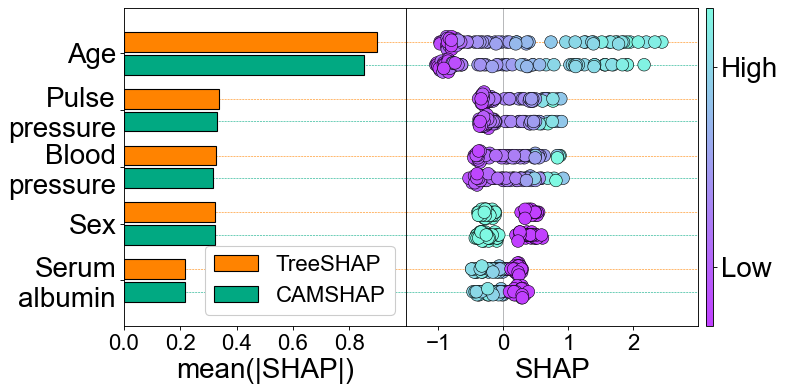

In [7]:
benchmarks.plotTopShap()